### XGBOOST 
Algoritmo:  XGBOOST
Variables:  dia, noche, festivos
SE probaron todas las otras variables, incluyendo info de la fecha, y destruían valor en los indicadores

In [531]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta


In [532]:
dfCOESBase = pd.read_excel('DemandaCOES.xlsx', skiprows=3)
dfCOESBase = dfCOESBase[['FECHA','EJECUTADO']]
dfCOESBase['FECHA'] = pd.to_datetime(dfCOESBase['FECHA'], format='%d/%m/%Y %H:%M')

# Devolvemos todo 30 minutos para que asi no tengamos fechas del dia siguiente.
# Antes del cambio  las 14:00 implicaban datos desde las 13:30 hasta las 14.  Luego del cambio 14 significará desde las 14 hasta las 14:30
# Esto era problemático, porque si no se hace el cambio hay que incluir la primera hora del dia siguiente (0), pues representaba los datos
# desde las 11:30pm hasta las 0.   Al hacer el cambio, solo se debe mirar el dia de hoy, pues las 11:30pm cubren los datos 
# desde las 23:30 hasta antes de las 0
dfCOESBase['FECHA']= dfCOESBase['FECHA'] - pd.Timedelta(minutes=30)

# Creamos variables adicionales
dfCOESBase['Mes'] = dfCOESBase['FECHA'].dt.month
dfCOESBase['ano'] = dfCOESBase['FECHA'].dt.year
dfCOESBase['fechaYYYYMMDD'] = dfCOESBase['FECHA'].dt.strftime('%Y-%m-%d')
dfCOESBase['fechaYYYYMMDD'] = pd.to_datetime(dfCOESBase['fechaYYYYMMDD'])
dfCOESBase['real'] = dfCOESBase['EJECUTADO']

# NOCHE: Extraemos el pico de la noche desde las 2pm hasta antes de las 11pm
dfCOESNoche = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 17) & (dfCOESBase['FECHA'].dt.hour < 23)].copy()
dfCOESNoche = dfCOESNoche.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESNoche.rename(columns={'EJECUTADO': 'Noche'}, inplace=True)

# DIA: Tomamos datos desde las 0 hasta antes de las 2pm
dfCOESDia = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 0) & (dfCOESBase['FECHA'].dt.hour < 14)].reset_index().copy()
dfCOESDia= dfCOESDia.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESDia.rename(columns={'EJECUTADO': 'Dia'}, inplace=True)

dfCOESTarde = dfCOESBase[(dfCOESBase['FECHA'].dt.hour >= 14) & (dfCOESBase['FECHA'].dt.hour < 17)].reset_index().copy()
dfCOESTarde= dfCOESTarde.groupby('fechaYYYYMMDD')['EJECUTADO'].max().reset_index()
dfCOESTarde.rename(columns={'EJECUTADO': 'Tarde'}, inplace=True)

# dfCOESTotal tiene los datos de DIA y NOCHE 
dfCOESTotal = pd.merge(dfCOESDia, dfCOESTarde, on='fechaYYYYMMDD', how='left')
dfCOESTotal = pd.merge(dfCOESTotal, dfCOESNoche, on='fechaYYYYMMDD', how='left')

# OJO, QUITAMOS LOS DATOS ANTERIORES AL 2021 PUES SON MUY ATIPICOS
dfCOESTotal = dfCOESTotal[dfCOESTotal['fechaYYYYMMDD'] >= '2021-01-01']

# obtenemos dos variables adicionales
dfCOESTotal['ano'] = dfCOESTotal['fechaYYYYMMDD'].dt.year
dfCOESTotal['mes'] = dfCOESTotal['fechaYYYYMMDD'].dt.month

dfCOESTotal = dfCOESTotal.reset_index(drop=True)




## **PRUEBAS:  se corta el archivo para simular otro dia**


In [533]:

# dfCOESTotal = dfCOESTotal[dfCOESTotal['fechaYYYYMMDD'] <= '2024-03-30']

## **CUIDADO:**
Como pueden llegar datos luego de las 2pm del ultimo dia, estos es mejor no tomarlos en cuenta pues podrían variar de dia a dia y el modelo podría confundirse.  Asi que el ultimo dia es mejor eliminar el dato de Noche

Al calcular **diaAPredecir** como el dia máximo que aparece en el archivo, esta variable indica qué dia hay que hacer todo este analisis.

In [534]:
diaAPredecir = dfCOESTotal['fechaYYYYMMDD'].max()
dfCOESTotal.loc[dfCOESTotal['fechaYYYYMMDD'] == diaAPredecir, 'Noche'] = np.nan
dfCOESTotal.tail()

,fechaYYYYMMDD,Dia,Tarde,Noche,ano,mes
1183,2024-03-29,6682.70887,6485.00370,7138.48225,2024,3
1184,2024-03-30,7200.17800,6935.58222,7262.40741,2024,3
1185,2024-03-31,6576.77453,6524.72391,7223.41316,2024,3
1186,2024-04-01,7663.10715,7716.05489,7548.07212,2024,4
1187,2024-04-02,7928.08921,7891.03737,NaN,2024,4


In [535]:
# el vector listaResultadosFinales (fecha, esPico) indica los resultados para cada dia analizado
listaResultadosFinales = []

# estas listas permiten ir acumulando las predicciones para luego generar el dataframe dfPredicciones
listaFechasTotales = []
listaHorizontesTotales = []
listaYPredsTotales = []

# cuando se generan predicciones para varios dias, en este dataframe quedan todas.  
# Esto es común en validación y no tanto en prediccionesDiarias
dfFinalAcumulado = pd.DataFrame(columns=['fechaAnalisis', 'fecha','prediccion','real'])
dfFinalAcumulado['fechaAnalisis'] = pd.to_datetime(dfFinalAcumulado['fechaAnalisis'])
dfFinalAcumulado['fecha'] = pd.to_datetime(dfFinalAcumulado['fecha'])
dfFinalAcumulado['prediccion'] = dfFinalAcumulado['prediccion'].astype(float)
dfFinalAcumulado['real'] = dfFinalAcumulado['real'].astype(float)

print('analizando ', diaAPredecir)

# para una correcta simulación aseguramos que solo tengan acceso a la data anterior o igual a fechaAnalisis
# y hasta dos años atrás. 
dfCOES = dfCOESTotal[(dfCOESTotal['fechaYYYYMMDD'] <= diaAPredecir) 
                    & (dfCOESTotal['fechaYYYYMMDD'] > diaAPredecir - pd.DateOffset(years=2)) ].copy()
df = dfCOES.copy()
df.reset_index(drop=True, inplace=True)   

dfFestivos = pd.read_excel('Festivos peru.xlsx')
dfFestivos = dfFestivos[['diaYYYYMMDD']]
dfFestivos = dfFestivos.rename(columns ={'diaYYYYMMDD':'festivo'})
dfFestivos['festivo'] = pd.to_datetime(dfFestivos['festivo'], format='%Y%m%d')

def verificaFestivo(fecha):
    if fecha in dfFestivos['festivo'].values:
        return 1
    return 0
df['festivo'] = df['fechaYYYYMMDD'].apply(verificaFestivo)

# convierte la data a numpy, con una historia "historia" valores para cada variable
# y se genera un "y" con un horizonte en dias a futuro.  Horizonte= 0 predice la noche
# del dia i.   horizonte=1 predice la siguiente noche y así sucesivamente.
def df_a_numpy(data1, data2, data3, historia, horizonte):
    X0, X1, X2,  y = [], [], [], []

    iMax = len(data1) - historia - horizonte -1

    for i in range(iMax+1):   # el for en python llega hasta iMax RECORDAR!!!
        X0.append(data1[i:i+historia +1])     # DIA.  OJO, LAS SERIES traen una menos del final
        X1.append(data2[i:i+historia])   #  sin incluir la TARDE del dia de hoy
        X2.append(data3[i:i+historia])   #  sin incluir la NOCHE del dia de hoy
        y.append(data3[i+historia + horizonte])  # si horizo=0, se predice la Noche actual
    return np.array(X0), np.array(X1), np.array(X2), np.array(y)


# =========================================
# Definir los parámetros del modelo XGBoost

params = {
    'colsample_bytree':0.8,
    'learning_rate':0.1,
    'max_depth':5,
    'n_estimators': 400,
    'subsample':0.8
}
historia = 60
# =========================================

# Inicializar el regresor XGBoost
regressor = xgb.XGBRegressor(**params)

listaFechas = []
listaHorizontes = []
listaYPreds = []

# Calculamos cuantos dias faltan para que termine el mes
ultimoDia = datetime(year=diaAPredecir.year, month=diaAPredecir.month, day=1)   
ultimoDia = ultimoDia + relativedelta(months=1)  
# ultimoDia = ultimoDia - relativedelta(days=1)  NOTA:  SE QUITA ESTA FILA PORQUE ESTO HACE QUE SE OBTENGAN MEJORES RESULTADOS ,,  MIRAR V9
diasFaltantes = (ultimoDia - diaAPredecir).days
print(ultimoDia, diasFaltantes)

for horizonte in range(0, diasFaltantes+1):   # se predicen 30 dias en el peor caso

    # OJO, LA ULTIMA FILA - HORIZONTE ES PARA PREDICCION!!
    # EL RESTO SI ES PARA TRAININ
    X0 , X1,  X2, y = df_a_numpy(df['Dia'], df['Tarde'], df['Noche'], historia, horizonte) 
    X3 = (df.loc[historia + horizonte:, ['festivo']] == 'festivo').astype(int)

    print(len(X0),len(X1), len(X2), len(X3))
    X = np.concatenate((X0, X1, X2, X3), axis=-1)

    XTrain = X[:-1, :]  # la ultima fila es para predecir, el resto es para entrenar
    yTrain = y[:-1]     # la ultima fila es para predecir, el resto es para entrenar

    XPred = X[-1:, :]   # la ultima fila es para predecir.

    regressor.fit(XTrain, yTrain)

    yPred = regressor.predict(XPred)

    listaFechas.append(diaAPredecir)
    listaHorizontes.append(horizonte)
    listaYPreds.append(yPred[0])

listaFechasTotales.extend(listaFechas)
listaHorizontesTotales.extend(listaHorizontes)
listaYPredsTotales.extend(listaYPreds)


analizando  2024-04-02 00:00:00
2024-05-01 00:00:00 29
671 671 671 671
670 670 670 670
669 669 669 669
668 668 668 668
667 667 667 667
666 666 666 666
665 665 665 665
664 664 664 664
663 663 663 663
662 662 662 662
661 661 661 661
660 660 660 660
659 659 659 659
658 658 658 658
657 657 657 657
656 656 656 656
655 655 655 655
654 654 654 654
653 653 653 653
652 652 652 652
651 651 651 651
650 650 650 650
649 649 649 649
648 648 648 648
647 647 647 647
646 646 646 646
645 645 645 645
644 644 644 644
643 643 643 643
642 642 642 642


In [536]:
dfPrediccion =pd.DataFrame({'fecha': listaFechasTotales, 'horizonte': listaHorizontesTotales, 'prediccion': listaYPredsTotales})
dfPrediccion.to_excel('dfPrediccion.xlsx')
dfPrediccion.rename(columns={'fecha': 'fechaAnalisis'}, inplace=True)
dfPrediccion['fechaAnalisis'] = dfPrediccion['fechaAnalisis'].dt.date
dfPrediccion['fechaAnalisis'] = pd.to_datetime(dfPrediccion['fechaAnalisis'])
dfPrediccion['fecha'] = dfPrediccion['fechaAnalisis'] + pd.to_timedelta(dfPrediccion['horizonte'], unit='D')
dfPrediccion = dfPrediccion[['fechaAnalisis','fecha','prediccion']]
dfPrediccion.tail()

,fechaAnalisis,fecha,prediccion
25,2024-04-02,2024-04-27,7541.927734
26,2024-04-02,2024-04-28,7513.151367
27,2024-04-02,2024-04-29,7484.749512
28,2024-04-02,2024-04-30,7543.058105
29,2024-04-02,2024-05-01,7481.060547


## **Prediccion vs Validacion**
Cuando se hacen predicciones diarias en producción, no se conoce el valor real de los dias que faltan.  
Cuando se hacen VALIDACIONES, si se conocen.  Por eso el siguiente código difiere de 07_validacion

Por tanto, solo es traer de **dfCOESTotal**, los dias de este mes hasta ANTES del **diaAPredecir**

In [537]:
# creamos dfReal con la misma estructura que dfPrediccion
dfReal = dfPrediccion[dfPrediccion['prediccion']==-1]
dfReal['real'] = dfReal['prediccion']

# llenamos dfReal con los datos de dfCOESTotal hasta antes del diaAPredecir
primerDiaMes = diaAPredecir.replace(day=1)
dfTemp = dfCOESTotal[(dfCOESTotal['fechaYYYYMMDD'] >= primerDiaMes) & 
                        (dfCOESTotal['fechaYYYYMMDD'] < diaAPredecir)].copy()
dfTemp['fecha'] = dfTemp['fechaYYYYMMDD']
dfTemp['real'] = dfTemp['Noche']
dfTemp['fechaAnalisis'] = diaAPredecir

dfTemp = dfTemp[['fechaAnalisis','fecha','real']]
dfReal = pd.concat([dfReal, dfTemp], ignore_index=True)

# le adicioamos la columna real a dfPrediccion
dfPrediccion['real'] = np.nan


## **Prediccion vs Validacion: unir dfReal y dfPrediccion**
En prediccion debe hacerse un **concat** porque real solo tiene filas desde el primer dia del mes hasta antes del dia a predecir, mientras que predecir tiene filas desde el dia a predecir hasta el final del mes.

En Validación, dfReal tiene las filas de TODOS los dias del mes pues estos son conocidos y por tanto NO se hace **concat** sino **merge**

In [538]:
dfFinal = pd.concat([dfReal, dfPrediccion], ignore_index=True)
dfFinal['seriePrediccion'] = 0
dfFinal['seriePrediccion']= dfFinal['seriePrediccion'].mask(dfFinal['prediccion'].notnull(), dfFinal['prediccion']).mask(dfFinal['prediccion'].isnull(), dfFinal['real'])
dfFinal.tail()

,fechaAnalisis,fecha,prediccion,real,seriePrediccion
26,2024-04-02,2024-04-27,7541.927734,NaN,7541.927734
27,2024-04-02,2024-04-28,7513.151367,NaN,7513.151367
28,2024-04-02,2024-04-29,7484.749512,NaN,7484.749512
29,2024-04-02,2024-04-30,7543.058105,NaN,7543.058105
30,2024-04-02,2024-05-01,7481.060547,NaN,7481.060547


## **Cálculo de posibles PICOS**
Se calcula para los dos cortes escogidos (listaCortes) cuáles serían los posibles picos maximos.  Todo valor que sea igual o superior a estos valores se considerará un posible Pico

In [539]:
# obtenemos los picos predichos (maximo de seriePrediccion)
dfPicosMaximosPredichos = dfFinal.groupby('fechaAnalisis')['seriePrediccion'].idxmax()
dfPicosMaximosPredichos = dfFinal.loc[dfPicosMaximosPredichos]
dfPicosMaximosPredichos = dfPicosMaximosPredichos.rename(columns={'seriePrediccion': 'valorPicoPredicho', 'fecha': 'fechaPicoPredicho'})

# estos son los cortes finalistas
listaCortes = [0.017776] 
dfCortes = pd.DataFrame(listaCortes, columns=['corte'])

dfPicosMaximosPredichos = dfPicosMaximosPredichos.merge(dfCortes, how='cross')
dfPicosMaximosPredichos['picoSegunCorte'] = (1-dfPicosMaximosPredichos['corte'])*dfPicosMaximosPredichos['valorPicoPredicho']
dfPicosMaximosPredichos = dfPicosMaximosPredichos[['fechaAnalisis','corte','picoSegunCorte']]
dfPicosMaximosPredichos.head()

,fechaAnalisis,corte,picoSegunCorte
0,2024-04-02,0.017776,7555.934134


Ya con los picos Máximos predichos según corte, es posible saber qué dias se marcan como posibles picos.

In [540]:
dfPicosPredichos = dfFinal.merge(dfPicosMaximosPredichos, on='fechaAnalisis', how='inner')

dfPicosPredichos['picoPredicho'] = (dfPicosPredichos['seriePrediccion'] >= dfPicosPredichos['picoSegunCorte'])
dfPicosPredichos['mes'] = dfPicosPredichos['fechaAnalisis'].dt.strftime('%Y%m')
dfPicosPredichos =dfPicosPredichos[dfPicosPredichos['picoPredicho']==True]
dfPicosPredichos.tail()

,fechaAnalisis,fecha,prediccion,real,seriePrediccion,corte,picoSegunCorte,picoPredicho,mes
14,2024-04-02,2024-04-15,7562.975586,NaN,7562.975586,0.017776,7555.934134,True,202404
15,2024-04-02,2024-04-16,7580.808105,NaN,7580.808105,0.017776,7555.934134,True,202404
21,2024-04-02,2024-04-22,7568.421387,NaN,7568.421387,0.017776,7555.934134,True,202404
24,2024-04-02,2024-04-25,7583.684082,NaN,7583.684082,0.017776,7555.934134,True,202404
25,2024-04-02,2024-04-26,7564.288086,NaN,7564.288086,0.017776,7555.934134,True,202404


## Cambio 2024 03 26 solicitado por Claudio
Claudio solicita que del pasado, solo salga el pico máximo hasta ahora

In [541]:
# Filtrar las filas donde 'real' no sea NaN
df_real = dfFinal.dropna(subset=['real'])
maxReal = dfFinal['real'].max()


In [542]:
if not np.isnan(maxReal):
    fecha_maxReal = df_real.loc[df_real['real'].idxmax(), 'fecha']
else:
    fecha_maxReal = None

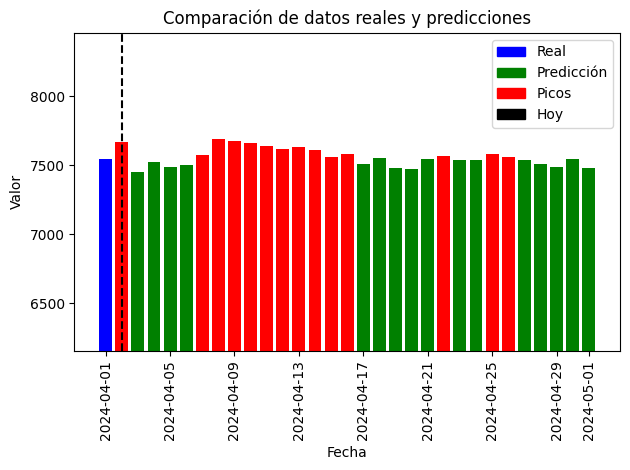

In [543]:

# Filtrar las filas donde 'prediccion' no sea NaN
df_prediccion = dfFinal.dropna(subset=['prediccion'])
maxPrediccion = dfPrediccion['prediccion'].max()

if not np.isnan(maxReal):
    maximo = max(maxReal, maxPrediccion)
else:
    maximo = maxPrediccion


fechas_picos_predichos = dfPicosPredichos['fecha']

# Graficamos los datos reales
plt.bar(df_real['fecha'], df_real['real'], color='blue', label='Real')

# Graficamos las predicciones
plt.bar(df_prediccion['fecha'], df_prediccion['prediccion'], color='green', label='Predicción')

# Resaltamos los picos predichos en rojo
for fecha in fechas_picos_predichos:
    if fecha in df_prediccion['fecha'].values:
        indice = df_prediccion[df_prediccion['fecha'] == fecha].index[0]
        plt.bar(df_prediccion['fecha'][indice], df_prediccion['prediccion'][indice], color='red')
    #if fecha in df_real['fecha'].values:
    if fecha == fecha_maxReal:
        indice = df_real[df_real['fecha'] == fecha].index[0]
        plt.bar(df_real['fecha'][indice], df_real['real'][indice], color='red')

fecha_hoy = diaAPredecir.strftime('%Y-%m-%d')
fecha_hoy = datetime.strptime(fecha_hoy, '%Y-%m-%d')
plt.axvline(x=fecha_hoy, color='black', linestyle='--', label='Hoy')

# Ajustamos la apariencia de la gráfica
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de datos reales y predicciones')
colores = {'Real': 'blue', 'Predicción': 'green', 'Picos': 'red', 'Hoy':'black'}
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colores.values()]
labels = colores.keys()
plt.legend(handles, labels)
plt.xticks(rotation=90)
plt.tight_layout()

plt.ylim(maximo*0.8, maximo*1.10)

# Mostramos la gráfica
temp_img_path = 'temp_plot.png'
plt.savefig(temp_img_path)
plt.show()

In [544]:
dfPicosPredichos

,fechaAnalisis,fecha,prediccion,real,seriePrediccion,corte,picoSegunCorte,picoPredicho,mes
1,2024-04-02,2024-04-02,7668.331543,NaN,7668.331543,0.017776,7555.934134,True,202404
6,2024-04-02,2024-04-07,7575.351562,NaN,7575.351562,0.017776,7555.934134,True,202404
7,2024-04-02,2024-04-08,7692.679199,NaN,7692.679199,0.017776,7555.934134,True,202404
8,2024-04-02,2024-04-09,7677.707520,NaN,7677.707520,0.017776,7555.934134,True,202404
9,2024-04-02,2024-04-10,7662.544922,NaN,7662.544922,0.017776,7555.934134,True,202404
10,2024-04-02,2024-04-11,7637.458984,NaN,7637.458984,0.017776,7555.934134,True,202404
11,2024-04-02,2024-04-12,7618.499023,NaN,7618.499023,0.017776,7555.934134,True,202404
12,2024-04-02,2024-04-13,7635.630371,NaN,7635.630371,0.017776,7555.934134,True,202404
13,2024-04-02,2024-04-14,7612.356445,NaN,7612.356445,0.017776,7555.934134,True,202404
14,2024-04-02,2024-04-15,7562.975586,NaN,7562.975586,0.017776,7555.934134,True,202404


In [545]:
from pptx import Presentation
from pptx.util import Inches
from pptx.dml.color import RGBColor

# Cargar la presentación
prs = Presentation('Reportar Resultados Template.pptx')

# Seleccionar la diapositiva deseada (por ejemplo, la primera diapositiva)
slide = prs.slides[1]

# Recorrer todas las imágenes en la diapositiva
# for i, shape in enumerate(slide.shapes):
#     print(i, '-' , shape.name, '-', shape.shape_type)

# 0, 6 y 11 son imagenes.  el 9 es un grafico
# 0:  calendario
# 6:  icono de cartones america
# 9:  la x blanca en un circulo rojo
# 11: es la gráfica que queremos actualizar!! y es de tipo PICTURE 13

newImagePath = 'temp_plot.png'
#slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))
slide.shapes.add_picture(image_file=newImagePath, left=Inches(0), top=Inches(2))

dfDiasAEliminarFinal = dfPicosPredichos[['fecha']].reset_index(drop=True)


table = slide.shapes.add_table(rows=dfDiasAEliminarFinal.size+1, cols=2, left=Inches(7.72), top=Inches(2.70), width=Inches(5), height=Inches(1)).table


# Agregar contenido a la tabla (opcional)
# Puedes acceder a las celdas de la tabla y agregar contenido a cada celda
table.cell(0, 0).text = "id"
table.cell(0, 1).text = "Día"


for index, row in dfDiasAEliminarFinal.iterrows():
    print('fila:',index+1, row['fecha'].strftime('%Y-%m-%d'))
    table.cell(index+1, 0).text = str(index)
    table.cell(index+1, 1).text = str(row['fecha'].strftime('%Y-%m-%d'))


# # Seleccionar la diapositiva tercera
# slide = prs.slides[2]
# newImagePath = 'temp_plot.png'
# slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))

# text_box = slide.shapes.add_textbox(Inches(7.72), Inches(2.39), Inches(5), Inches(0.8))

# # Agrega un párrafo de texto al cuadro de texto
# tf = text_box.text_frame
# p = tf.add_paragraph()
# p.text = "no se quee decir"

# # Ajusta el formato del texto
# p.font.size = Inches(0.5)
# p.font.bold = True
# color = RGBColor(0, 128, 0)  # Rojo (255, 0, 0) en formato RGB
# p.font.color.rgb = color

prs.save('Reportar Resultados.pptx')

fila: 1 2024-04-02
fila: 2 2024-04-07
fila: 3 2024-04-08
fila: 4 2024-04-09
fila: 5 2024-04-10
fila: 6 2024-04-11
fila: 7 2024-04-12
fila: 8 2024-04-13
fila: 9 2024-04-14
fila: 10 2024-04-15
fila: 11 2024-04-16
fila: 12 2024-04-22
fila: 13 2024-04-25
fila: 14 2024-04-26
